# PHYS247-Final Project  
## Convolutional Neural Network (CNN) Leaf Species Classifier
Steven Mills  
June 12, 2020

Use black and white silhouette images of leaves from various plant species to build a species classifier CNN

In [1]:
import os
import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image, ImageFilter
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
data_path = os.getcwd()
image_path = os.path.join(os.getcwd(), 'images')

#### load data from kaggle train.csv ####
df = pd.read_csv(os.path.join(data_path, 'train.csv'))
species_by_id = dict(zip(df.id, df.species))  # <-- lookup species by jpeg id

#### load images from jpegs, which are named as "<id>.jpg" ####
img_n = 150

x = []
y = []
for filename in os.listdir(image_path):
    if filename.endswith(".jpg"):
        id = np.int64(re.match(r'([0-9]+)\.jpg', filename).group(1))
        if id in species_by_id: # not all jpegs are labeled
            species = species_by_id[id]
            
            img = load_img(os.path.join(image_path, filename), color_mode = 'grayscale')
            img = img.filter(ImageFilter.FIND_EDGES)
            img = img.resize((img_n, img_n))
            
            img_np = np.array(img)
            #img_np = 255. - np.array(img)

            x.append(img_np)
            y.append(species)

X = np.array(x)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

y_enc = OneHotEncoder(sparse=False)
y = y_enc.fit_transform(np.array(y).reshape(-1, 1))

num_species = len(y_enc.categories_[0])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1337, stratify=y)

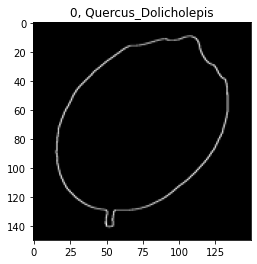

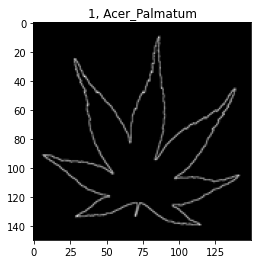

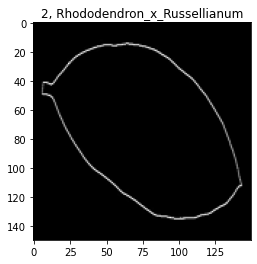

In [3]:
def plotit(a, title=''):
    plt.imshow(a.reshape(img_n, img_n), cmap='gray')
    if len(title):
        plt.title(title)
    plt.show()

for i in range(3):
    plotit(X_train[i], '%d, %s' % (i, y_enc.categories_[0][y_train[i].argmax()]))

In [4]:
print('train_shape', X_train.shape, y_train.shape)
print('test_shape', X_test.shape, y_test.shape)

train_shape (693, 150, 150, 1) (693, 99)
test_shape (297, 150, 150, 1) (297, 99)


In [5]:
from skimage.io import imread
from skimage.util import crop
from skimage.transform import resize

In [6]:
reshape_dx = (1, X_train.shape[1], X_train.shape[2], X_train.shape[3])
reshape_dy = (1, y_train.shape[1])

def append(x, y):
    # np.concatentate is very slow ...
    global X_train, y_train
    X_train = np.concatenate((X_train, x.reshape(reshape_dx)), axis=0)
    y_train = np.concatenate((y_train, y.reshape(reshape_dy)), axis=0)
    
def cropit(ii):
    return resize(crop(ii, ((0, 75), (0, 75), (0,0)), copy=False, order='K'), (img_n, img_n, 1), anti_aliasing=True)
    plotit(crop_img_np)
    
for i in range(X_train.shape[0]):
    img_np = X_train[i]
    append(np.rot90(img_np), y_train[i])
    append(np.fliplr(img_np), y_train[i])
    append(np.fliplr(np.rot90(img_np)), y_train[i])
    #append(np.flipud(img_np), y_train[i])
    #append(cropit(img_np), y_train[i]) # sorry, this is too slow!
    
n_augment = 3

In [7]:
print('train_shape', X_train.shape, y_train.shape)
print('test_shape', X_test.shape, y_test.shape)

train_shape (2772, 150, 150, 1) (2772, 99)
test_shape (297, 150, 150, 1) (297, 99)


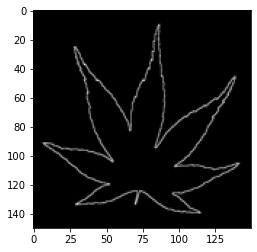

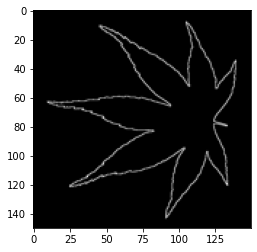

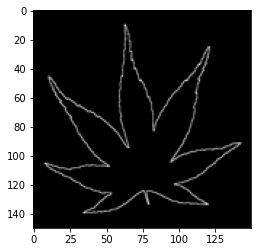

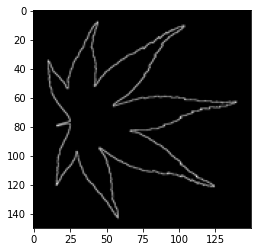

In [8]:
n_train = 693
idx = 1
plotit(X_train[idx])
for i in range(n_augment):
    plotit(X_train[n_train + i + idx*(n_augment)])

In [9]:
X_train=np_utils.normalize(X_train,axis=1)
X_test=np_utils.normalize(X_test,axis=1)

In [12]:
np.random.seed(42)
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model=Sequential()

model.add(Conv2D(64, 3, input_shape=(img_n, img_n, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.5))
model.add(Conv2D(128, 5, activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))

model.add(Dropout(0.5))
model.add(Conv2D(256, 7, activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))

model.add(Flatten())

model.add(Dropout(0.5))
model.add(Dense(200, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(num_species, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 200
model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), batch_size=32, epochs=EPOCHS)
model.summary()

Train on 2772 samples, validate on 297 samples
Epoch 1/200
2772/2772 [==============================] - 5s 2ms/step - loss: 4.5846 - accuracy: 0.0123 - val_loss: 4.4082 - val_accuracy: 0.0269
Epoch 2/200
2772/2772 [==============================] - 5s 2ms/step - loss: 4.2751 - accuracy: 0.0299 - val_loss: 3.9410 - val_accuracy: 0.0976
Epoch 3/200
2772/2772 [==============================] - 5s 2ms/step - loss: 3.9503 - accuracy: 0.0631 - val_loss: 3.4975 - val_accuracy: 0.1785
Epoch 4/200
2772/2772 [==============================] - 5s 2ms/step - loss: 3.6008 - accuracy: 0.1100 - val_loss: 3.0812 - val_accuracy: 0.2290
Epoch 5/200
2772/2772 [==============================] - 5s 2ms/step - loss: 3.2059 - accuracy: 0.1735 - val_loss: 2.7991 - val_accuracy: 0.2896
Epoch 6/200
2772/2772 [==============================] - 5s 2ms/step - loss: 2.9368 - accuracy: 0.2067 - val_loss: 2.4930 - val_accuracy: 0.3670
Epoch 7/200
2772/2772 [==============================] - 5s 2ms/step - loss: 2.7045

Epoch 57/200
2772/2772 [==============================] - 5s 2ms/step - loss: 0.6096 - accuracy: 0.8023 - val_loss: 1.0540 - val_accuracy: 0.6700
Epoch 58/200
2772/2772 [==============================] - 5s 2ms/step - loss: 0.5901 - accuracy: 0.8052 - val_loss: 1.1236 - val_accuracy: 0.6835
Epoch 59/200
2772/2772 [==============================] - 5s 2ms/step - loss: 0.5638 - accuracy: 0.8106 - val_loss: 1.1411 - val_accuracy: 0.7003
Epoch 60/200
2772/2772 [==============================] - 5s 2ms/step - loss: 0.5469 - accuracy: 0.8146 - val_loss: 1.0861 - val_accuracy: 0.6902
Epoch 61/200
2772/2772 [==============================] - 5s 2ms/step - loss: 0.5988 - accuracy: 0.7983 - val_loss: 1.1351 - val_accuracy: 0.7003
Epoch 62/200
2772/2772 [==============================] - 5s 2ms/step - loss: 0.5136 - accuracy: 0.8304 - val_loss: 1.0897 - val_accuracy: 0.6835
Epoch 63/200
2772/2772 [==============================] - 5s 2ms/step - loss: 0.4992 - accuracy: 0.8431 - val_loss: 1.0904 -

2772/2772 [==============================] - 5s 2ms/step - loss: 0.3681 - accuracy: 0.8874 - val_loss: 1.1059 - val_accuracy: 0.7340
Epoch 114/200
2772/2772 [==============================] - 5s 2ms/step - loss: 0.3392 - accuracy: 0.8849 - val_loss: 1.1603 - val_accuracy: 0.7172
Epoch 115/200
2772/2772 [==============================] - 5s 2ms/step - loss: 0.3626 - accuracy: 0.8770 - val_loss: 1.1729 - val_accuracy: 0.7071
Epoch 116/200
2772/2772 [==============================] - 5s 2ms/step - loss: 0.3708 - accuracy: 0.8791 - val_loss: 1.2282 - val_accuracy: 0.7138
Epoch 117/200
2772/2772 [==============================] - 5s 2ms/step - loss: 0.3565 - accuracy: 0.8849 - val_loss: 1.1601 - val_accuracy: 0.7205
Epoch 118/200
2772/2772 [==============================] - 5s 2ms/step - loss: 0.3165 - accuracy: 0.8990 - val_loss: 1.1895 - val_accuracy: 0.7104
Epoch 119/200
2772/2772 [==============================] - 5s 2ms/step - loss: 0.3347 - accuracy: 0.8892 - val_loss: 1.2401 - val_ac

Epoch 169/200
2772/2772 [==============================] - 5s 2ms/step - loss: 0.2500 - accuracy: 0.9185 - val_loss: 1.1371 - val_accuracy: 0.7508
Epoch 170/200
2772/2772 [==============================] - 5s 2ms/step - loss: 0.2456 - accuracy: 0.9224 - val_loss: 1.2989 - val_accuracy: 0.7037
Epoch 171/200
2772/2772 [==============================] - 5s 2ms/step - loss: 0.2535 - accuracy: 0.9167 - val_loss: 1.1873 - val_accuracy: 0.7374
Epoch 172/200
2772/2772 [==============================] - 5s 2ms/step - loss: 0.2688 - accuracy: 0.9098 - val_loss: 1.1491 - val_accuracy: 0.7407
Epoch 173/200
2772/2772 [==============================] - 5s 2ms/step - loss: 0.2757 - accuracy: 0.9159 - val_loss: 1.1974 - val_accuracy: 0.7542
Epoch 174/200
2772/2772 [==============================] - 5s 2ms/step - loss: 0.2621 - accuracy: 0.9105 - val_loss: 1.0521 - val_accuracy: 0.7643
Epoch 175/200
2772/2772 [==============================] - 5s 2ms/step - loss: 0.2583 - accuracy: 0.9192 - val_loss: 1

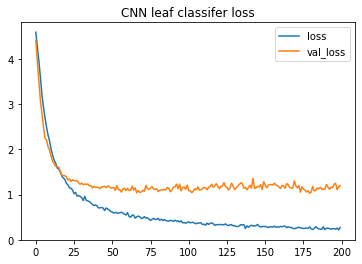

In [17]:
history=pd.DataFrame(model.history.history)
history[['loss','val_loss']].plot(title='CNN leaf classifer loss')

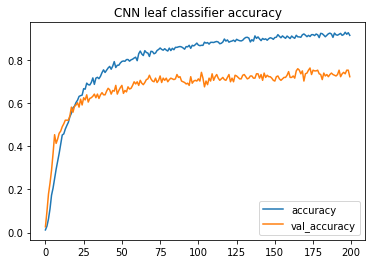

In [18]:
history[['accuracy','val_accuracy']].plot(title='CNN leaf classifier accuracy')

The Test Accuracy of the model is: 72.391 %



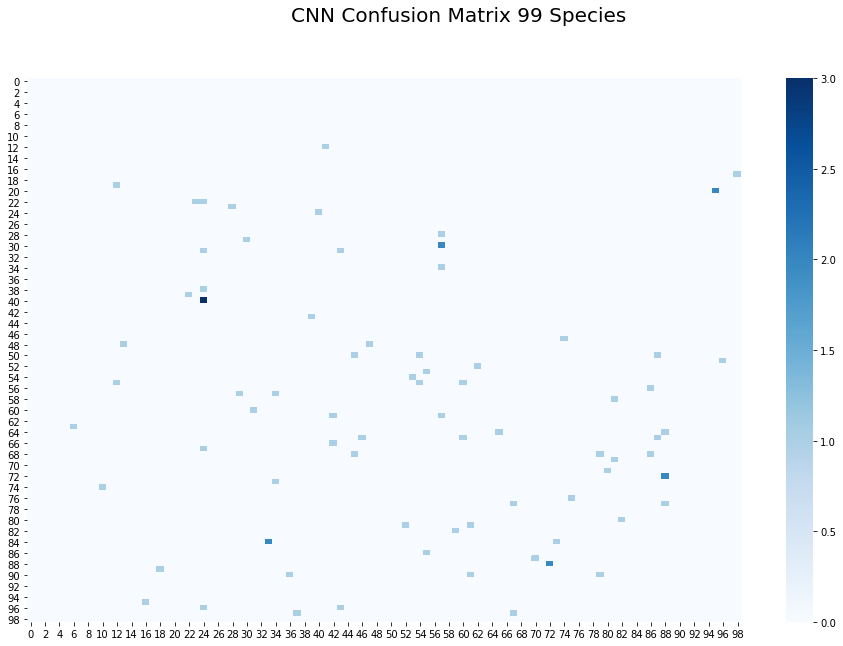

In [19]:
h = model.predict(X_test)
y_predict = np.array([h[q].argmax() for q in range(h.shape[0])])
y_true = np.array([y_test[q].argmax() for q in range(y_test.shape[0])])

print("The Test Accuracy of the model is: {:.3f} %".format(accuracy_score(y_true, y_predict) * 100.))
print()

cmatrix = confusion_matrix(y_true, y_predict)
np.fill_diagonal(cmatrix, 0.)
fig = plt.figure(figsize=(16,10))
sns.heatmap(cmatrix, cmap="Blues")
fig.suptitle('CNN Confusion Matrix %d Species' % (num_species), fontsize=20)
plt.show()

3 / 3 misclassifications of 40 Magnolia_Salicifolia as 24 Cornus_Macrophylla
2 / 3 misclassifications of 20 Celtis_Koraiensis as 95 Ulmus_Bergmanniana
2 / 3 misclassifications of 72 Quercus_Phellos as 88 Rhododendron_x_Russellianum
2 / 3 misclassifications of 88 Rhododendron_x_Russellianum as 72 Quercus_Phellos
2 / 3 misclassifications of 30 Eucalyptus_Urnigera as 57 Quercus_Chrysolepis


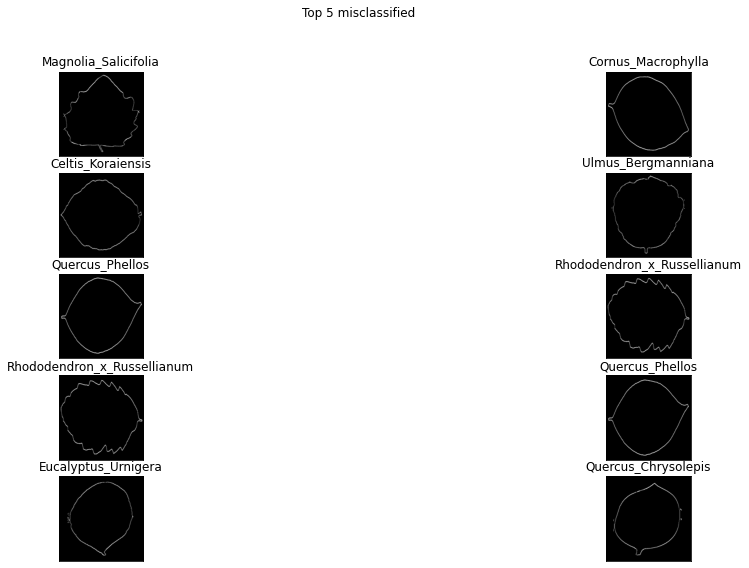

In [20]:
# print diagnostic info
np.fill_diagonal(cmatrix, 0.)
fig, axs = plt.subplots(5, 2, figsize=(18, 9))
fig.suptitle('Top 5 misclassified')
row = 0
for (cnt, class2, class1) in sorted([(cmatrix[q].max(), cmatrix[q].argmax(), q) for q in range(cmatrix.shape[0])], reverse=True)[:5]:
    print(cnt, '/', len([q for q in range(y_test.shape[0]) if y_test[q].argmax() == row]), 'misclassifications of', class1, y_enc.categories_[0][class1], 'as', class2, y_enc.categories_[0][class2])
    idx1 = [q for q in range(y_test.shape[0]) if y_test[q].argmax() == class1][0]
    idx2 = [q for q in range(y_test.shape[0]) if y_test[q].argmax() == class2][0]
    axs[row][0].imshow(X_train[idx1].reshape(img_n, img_n), cmap='gray')
    axs[row][1].imshow(X_train[idx2].reshape(img_n, img_n), cmap='gray')
    axs[row][0].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    axs[row][1].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    axs[row][0].set_title(y_enc.categories_[0][class1])
    axs[row][1].set_title(y_enc.categories_[0][class2])
    row +=1
plt.show()

### Classification with k nearest neighbors  

In [ ]:
df_ = pd.read_csv(os.path.join(data_path, 'train.csv'))
species_by_id = dict(zip(df_.id, df_.species))
df_.drop(['id'], axis=1, inplace=True)

le = LabelEncoder().fit(df_['species'])
df_['species'] = le.transform(df_['species'])
species = df_['species']
df_.drop(['species'], axis=1, inplace=True)
species

In [ ]:
#scaler = StandardScaler().fit(df_.values)
#scaled_train = scaler.transform(df_.values)

X_train, X_test, y_train, y_test = train_test_split(df_, species, test_size=0.3, random_state=1337)

from sklearn.neighbors import KNeighborsClassifier

for i in range(1, 7):
    classifier = KNeighborsClassifier(i).fit(X_train, y_train)
    h = classifier.predict(X_test)
    acc = accuracy_score(y_test, h)
    print('%d nearest, accuracy = %3.3f' % (i, acc))

In [ ]:
classifier = KNeighborsClassifier(1).fit(X_train, y_train)
h = classifier.predict(X_test)

y_predict = h
y_true = y_test


print("The Test Accuracy of the model is: {:.3f} %".format(accuracy_score(y_true, y_predict) * 100.))
print()

cmatrix = confusion_matrix(y_true, y_predict)
np.fill_diagonal(cmatrix_na, 0.)
fig = plt.figure(figsize=(16,10))
sns.heatmap(cmatrix, cmap='Blues')
fig.suptitle('Confusion Matrix %d Species' % (num_species), fontsize=20)
plt.show()

In [ ]:
# print diagnostic info
np.fill_diagonal(cmatrix, 0.)
for (cnt, class2, class1) in sorted([(cmatrix[q].max(), cmatrix[q].argmax(), q) for q in range(cmatrix.shape[0])], reverse=True):
    print(cnt, 'misclassifications of', class1, le.classes_[class1], 'as', class2, le.classes_[class2])